In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tqdm.keras import TqdmCallback
import pandas as pd
import numpy as np
import os
import shutil
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from metrics import metrics
from ipywidgets import widgets, interact
from IPython.display import clear_output, display
from plotly_dataframe import plot 
from plotly_plt_predictions import plot_predictions
import matplotlib.pyplot as plt
from plot_map import choropleth
from tool_datetime import next_datetimes

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Selection of the gpu.
GPU = [0]
# Set the selected gpu for the usage.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(x) for x in GPU)  

# Forecasting - Food Consumpion Score (FCS)

In [3]:
# Load the original data of the second version of fcs indicator released by wfp.
df = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq
df.columns.names = ["AdminStrata", "Indicator"]

In [4]:
#plot(df, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [5]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = True
# Fix a random seed if you want to fix the training process of the neural network.
FIX_SEED = False
# Define the frequency datetime of the time-series.
FREQ = df.index.freq

In [6]:
# Recursive forecasting if N_OUT < TEST. If N_OUT = TEST is a direct forecast. N_OUT > TEST is not permitted.
N_OUT = 10

if N_OUT == TEST:
    FORECAST = "Direct"
else:
    FORECAST = "Recursive"

In [7]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [8]:
# If you want to standardize data.
STANDARDIZE = True

In [9]:
# Function that standardize the time-series independently to each other.
means = dict()
stds = dict()
if STANDARDIZE:
    def standardize(serie):
        mean = serie.mean()
        means[serie.name] = mean
        std = serie.std()
        stds[serie.name] = std
        serie = (serie - mean)/std
        return serie

    train = train.apply(standardize)

In [10]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")
os.makedirs(dir + "/ckpt_trials")
for admin in df.columns.get_level_values(0).unique():
    os.makedirs(dir + "/ckpt_trials/" + admin)

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)
    f.write("N_OUT: %d \n" % N_OUT)
    f.write("STANDARDIZE: %d \n" % STANDARDIZE)

# MLP

In [11]:
# Convert history into inputs X and outputs y.
def to_supervised(group, n_features, n_input, n_out, validation = False, shuffle = False):
    # Assuming to pass a dataframe 'group' that has a level 0 with the name of the time-series and at level 1 its multivariate time-series (in this case only a variate).
    group.columns = group.columns.droplevel()
    # If the forecast is direct (and involve a dataframe with multivariate time-series) is necessary to specify the name of the variate time-series to predict.
    # If the forecast is recursive (even if there are multivariate time-series) all the variates are recursive predicted.
    if FORECAST == "Direct":
        serie_to_predict = group["FCS"]
        serie_to_predict = serie_to_predict.values
        
    group = group.values

    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time.
    for _ in range(len(group)):
        # Define the end of the input sequence.
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance.
        if out_end <= len(group):
            x_input = group[in_start:in_end]
            x_input = x_input.reshape((len(x_input), n_features))
            X.append(x_input)
            if FORECAST == "Direct":
                y.append(serie_to_predict[in_end:out_end])
            else:
                y.append(group[in_end:out_end])
        # Move along one time step.
        in_start += 1
      
    # If the validation option is set, I extrapolate some data to use for validation:
    # If shuffle is set to True the data points for the validation phase are taken randomly from the training data.
    # If shuffle is set to False the data points for the validation phase are taken in order: the last points as an holdout validation.
    if validation:
        X = np.array(X)
        y = np.array(y)
        X_train, X_val = train_test_split(X, test_size = 0.05, shuffle = shuffle)
        y_train, y_val = train_test_split(y, test_size = 0.05, shuffle = shuffle)
        return pd.Series({"X_train": np.array(X_train), "y_train": np.array(y_train), 
                          "X_val": np.array(X_val), "y_val": np.array(y_val)})
    else:    
        return pd.Series({"X": np.array(X), "y": np.array(y)})

In [12]:
# Define the model.
def MLP(X, y, n_out, n_input, n_nodes, dropout, n_epochs, batch_size, optimizer, shuffle, adminstrata, n_features, 
        trial = None, fix_seed = False, save = False): 
    # Fix the random seed of the training.
    if fix_seed:
        np.random.seed(0)

    # Define the model.
    model = Sequential()
    model.add(Dense(n_nodes, activation = "relu", input_dim = n_input))
    model.add(Dropout(dropout))
    model.add(Dense(n_out))
    model.compile(loss = "mse", optimizer = optimizer)

    if save:
        # Define the training checkpoint where saving the results that gives the lower training error for the given attempt (trial) of the given time-series.
        filepath = dir + "/ckpt_trials/" + adminstrata +"/model_" + adminstrata + "_trial%d.h5" % trial 
        checkpoint = ModelCheckpoint(filepath, monitor = "loss", verbose = 0, save_best_only = True, mode = "min")
        callbacks = [checkpoint, TqdmCallback(verbose = 1)]
    else:
        callbacks = [TqdmCallback(verbose = 1)]
        
    # Fit network.
    model.fit(X, y, epochs = n_epochs, batch_size = batch_size, verbose = 0, shuffle = shuffle, callbacks = callbacks)    

    return model

# Optional grid search

In [13]:
# Define the parameters to grid search.
if GRID_SEARCH:
    space = {"n_input": hp.randint("n_steps", 5, 120), # The number of time steps within each subsequence.
             "n_epochs": hp.randint("n_epochs", 1, 100), # The number of epochs.
             "batch_size": hp.randint("batch_size", 1, 64), # The batch size.
             "n_nodes": hp.randint("n_nodes", 20, 1000), # The number of MLP units to use in the hidden layer.
             "dropout": hp.uniform("dropout", 0, 1), # Dropout layer.
             "optimizer": hp.choice("optimizer", ["adam", "rmsprop"]), # The optimizer for the training phase.
             "shuffle": hp.choice("shuffle", [True, False]) # If you want to shuffle the data during training.
            }
else:
    space = {"n_input": 80, 
             "n_epochs": 1,
             "batch_size": 8,
             "n_nodes": 50, 
             "dropout": 0.5, 
             "optimizer": "adam", 
             "shuffle": False
            }

In [14]:
def hyperparameters(space, group):
    # Define the name of the time-series.
    adminstrata = group.name
    # Define the number of features for the selected adminstrata.
    n_features = len(group.columns.get_level_values(1).unique())
    try:        
        print("Grid search for adminstrata:", adminstrata)
        # Create the training samples (X, y).
        data = group.groupby(level = 0, axis = 1).apply(lambda x: to_supervised(x, n_features, space["n_input"], N_OUT, True, space["shuffle"]))        
        # Training data.
        X_train = np.concatenate(data.loc["X_train"])
        y_train = np.concatenate(data.loc["y_train"]) 
        # Not consider the feature part for MLP.
        X_train = np.squeeze(X_train, axis = 2)
        if FORECAST == "Recursive":
            y_train = np.squeeze(y_train, axis = 2)

        model = MLP(X_train, y_train, N_OUT, int(space["n_input"]), int(space["n_nodes"]), space["dropout"], 
                    int(space["n_epochs"]), int(space["batch_size"]), space["optimizer"], space["shuffle"], 
                    adminstrata, n_features, None, FIX_SEED, False)   

        # Validation data.
        X_val = np.concatenate(data.loc["X_val"])
        X_val = X_val.reshape((X_val.shape[0], space["n_input"], n_features))
        y_val = np.concatenate(data.loc["y_val"]) 
        # Not consider the feature part for MLP.
        X_val = np.squeeze(X_val, axis = 2)
        if FORECAST == "Recursive":
            y_val = np.squeeze(y_val, axis = 2)

        pred = model.predict(X_val, batch_size = int(space["batch_size"]), verbose = 0)
        error = metrics(y_val, pred, ERROR).compute()

        # Recursive save results.
        space["loss"] = error
        df_space = pd.DataFrame(space, index = [0])
        filename = dir + "/grid_search/" + adminstrata + ".csv"
        df_space.to_csv(filename, index = False, header = (not os.path.exists(filename)), mode = "a")

        clear_output(wait = True)
        K.clear_session()
    except:
        error = np.inf
        clear_output(wait = True)
        K.clear_session()

    return {"loss": error, "status": STATUS_OK}

In [15]:
def GridSearch(group):
    adminstrata = group.name
    # The searching of the best minimum combination of parameters.
    trials = Trials()
    best = fmin(fn = lambda x: hyperparameters(x, group),
                space = space,
                algo = tpe.suggest,
                max_evals = 200, 
                trials = trials, 
                verbose = False)      
    clear_output(wait = True)
    return best

In [16]:
def NoGridSearch(group):
    adminstrata = group.name
    space["loss"] = 0
    df_space = pd.DataFrame(space, index = [0])
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    df_space.to_csv(filename, index = False)

In [17]:
if GRID_SEARCH:    
    _ = train.groupby(level = 0, axis = 1).apply(GridSearch)
else:
    _ = train.groupby(level = 0, axis = 1).apply(NoGridSearch)

# Forecasting

In [18]:
# The number of simulation to perform during inference phase for each time-serie (being a sthocastic model).
n_trials = 10

In [19]:
figures = dict()
df_prediction = dict()

In [20]:
def quantile_25(x):
    return x.quantile(q = 0.25)

def quantile_75(x):
    return x.quantile(q = 0.75)

In [21]:
# Forecast.
def forecast(group, model_name, n_out, n_input, n_features): 

    if FORECAST == "Recursive":
        iterations = int(np.ceil(TEST/n_out))
        # Load the model.
        model = load_model(model_name, compile = False)
        # Compute prediction.
        for i in range(iterations):
            x_input = group.tail(n_input).values
            x_input = x_input.reshape((1, n_input))
            y_hats = model.predict(x_input, verbose = 0).flatten()
            y_hats = np.vstack(np.split(y_hats, n_out))
            y_hats = pd.DataFrame(y_hats, index = next_datetimes(group.index[-1], n_out, FREQ), columns = group.columns)
            group = group.append(y_hats)  

        K.clear_session()

        y_hats = group[-(n_out)*iterations:]
        y_hats = y_hats.head(TEST)
    if FORECAST == "Direct":
        # Load the model.
        model = load_model(model_name, compile = False)
        # Compute prediction.
        x_input = group.tail(n_input).values
        x_input = x_input.reshape((1, n_input))
        y_hats = model.predict(x_input, verbose = 0).flatten()
        y_hats = pd.Series(y_hats, index = next_datetimes(group.index[-1], n_out, FREQ))

        K.clear_session()

    return y_hats

In [22]:
def inference(group, n_trials, n_out, n_input, n_features):
    # Define the name of the current adminstrata.
    adminstrata = group.name
    group = group.droplevel(0, axis = 1)

    df_trials = pd.Series([])
    for trial in range(n_trials):
        # Fit the model.
        y_hats = forecast(group, dir + "/ckpt_trials/" + adminstrata +"/model_" + adminstrata + "_trial%d.h5" % trial, n_out, n_input, n_features) 
        # Inference FCS.
        if FORECAST == "Direct":
            y_hats = pd.DataFrame(y_hats, columns = ["FCS"])
        if FORECAST == "Recursive":
            y_hats = y_hats[["FCS"]]
        y_hats.name = trial
        df_trials = pd.concat([df_trials, y_hats], axis = 1)

    df_trials.dropna(axis = 1, inplace = True)
    results = df_trials.agg([np.mean, quantile_25, quantile_75], axis = "columns")

    # FCS
    serie = group["FCS"]

    if STANDARDIZE:
        serie = serie*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
        predicted_mean = results["mean"]*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
        predicted_quantile_25 = results["quantile_25"]*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
        predicted_quantile_75 = results["quantile_75"]*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
    else:
        predicted_mean = results["mean"]
        predicted_quantile_25 = results["quantile_25"]
        predicted_quantile_75 = results["quantile_75"]
        
    # The entire original FCS time-series.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted_mean, predicted_quantile_25, predicted_quantile_75, title = adminstrata, 
                              plotly = False, save = True, dir_to_save = dir + "/images/")
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted_mean
    
    # Compute the error.
    error = metrics(test[adminstrata]["FCS"], predicted_mean, ERROR).compute()

    return error

In [23]:
def predict(group):   
    # Save the name of the adminstrata.
    adminstrata = group.name
    print("Training & inference for the adminstrata:", adminstrata)
    
    # Save the number of features for the selected time-series adminstrata.
    n_features = len(group.columns.get_level_values(1).unique())
    # Load the best parameters for the selected adminstrata: those obtained using a grid search or those manually set for all the adminstratas.
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    params = pd.read_csv(filename)
    best_params = params.loc[params.loss.idxmin()]  
    
    # Create the training samples (X, y) for the selected adminstrata.
    data = group.groupby(level = 0, axis = 1).apply(lambda x: to_supervised(x, n_features, int(best_params["n_input"]), N_OUT, False))   
    
    # New training data: training data + validation data.
    X = np.concatenate(data.loc["X"])
    y = np.concatenate(data.loc["y"])    
    # Not consider the feature part for MLP.
    X = np.squeeze(X, axis = 2)
    if FORECAST == "Recursive":
        y = np.squeeze(y, axis = 2)

    for trial in range(n_trials):
        print("--- Trial %d/%d" % (trial + 1, n_trials))
        model = MLP(X, y, N_OUT, int(best_params["n_input"]), int(best_params["n_nodes"]), best_params["dropout"], 
                    int(best_params["n_epochs"]), int(best_params["batch_size"]), best_params["optimizer"], 
                    best_params["shuffle"], adminstrata, n_features, trial, FIX_SEED, True)            
        clear_output(wait = True)
        K.clear_session()
    
    errors = group.groupby(level = 0, axis = 1).apply(lambda x: inference(x, n_trials, N_OUT, int(best_params["n_input"]), n_features))
    
    
    return errors.values[0]

In [24]:
errors = train.groupby(level = 0, axis = 1).apply(predict)

--- Trial 10/10


In [25]:
errors.mean()

42.71893199855378

In [26]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [27]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

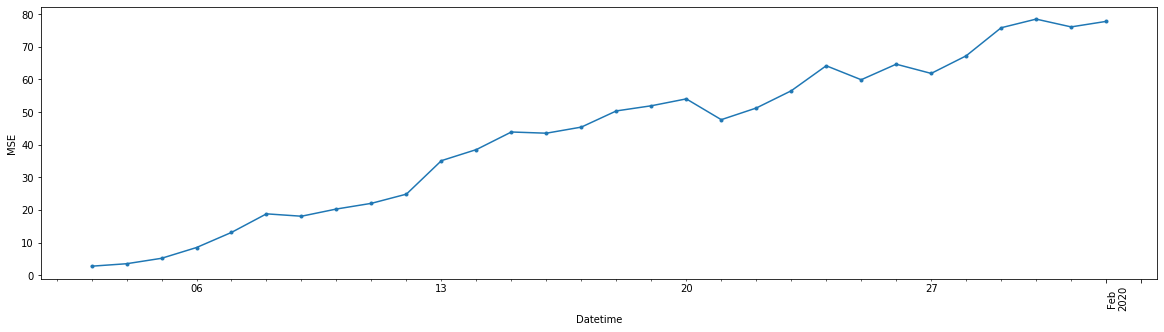

In [28]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
prediction_time = test.transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

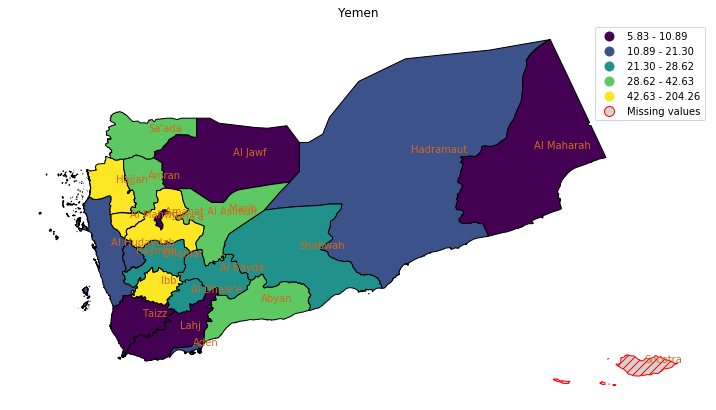

In [29]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [30]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [31]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/MLP.csv")